## Домашнее задание №9
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("{} device is available".format(device))

cpu device is available


#### 1. Загрузка данных.

In [3]:
with open("onegin.txt", "r") as iofile:
    text = iofile.readlines()

text = "".join([x.replace("\t\t", "").lower() for x in text])

#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [4]:
tokens = sorted(set(text.lower())) + ["<sos>"]
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [5]:
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx["<sos>"]


def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size * seq_length - 1)
    data = np.array(
        text_encoded[start_index : start_index + batch_size * seq_length]
    ).reshape((batch_size, -1))
    yield np.hstack((start_column, data))

Пример батча:

In [6]:
ex_batch = next(generate_chunk())
ex_batch, ex_batch.shape

(array([[83,  1, 58, ..., 58, 72, 50],
        [83,  1, 48, ...,  0, 62, 64],
        [83, 49, 73, ...,  1, 62, 56],
        ...,
        [83, 45,  1, ..., 59,  1, 58],
        [83, 45, 69, ...,  0, 59, 49],
        [83, 58, 53, ..., 62,  1, 58]]),
 (256, 101))

Далее вам предстоит написать код для обучения модели и генерации текста.

In [8]:
class CharRNN(nn.Module):
    def __init__(
        self, num_tokens, embedding_dims, hidden_size, num_layers, batch_first=True
    ):
        super().__init__()
        self.emb = nn.Embedding(num_tokens, embedding_dims)
        self.rnn = nn.RNN(
            embedding_dims, hidden_size, num_layers, batch_first=batch_first
        )
        self.h2logits = nn.Linear(hidden_size, num_tokens)

    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.h2logits(h_seq)
        return next_logits


model = CharRNN(num_tokens=num_tokens, embedding_dims=16, hidden_size=64, num_layers=1)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())
history = []

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

In [9]:
NUM_TRAIN_ITERS = 1000

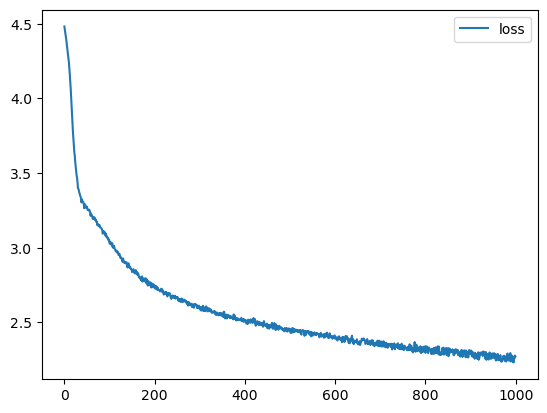

In [10]:
for i in range(NUM_TRAIN_ITERS):
    x_batch = next(generate_chunk())
    x_batch = torch.tensor(x_batch, dtype=torch.int64)

    logits_seq = model(x_batch)

    loss = loss_fn(
        logits_seq[:, :-1].contiguous().view(-1, num_tokens),
        x_batch[:, 1:].contiguous().view(-1),
    )

    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())
    if (i + 1) % 10 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [11]:
def generate_sample(
    char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device
):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    if seed_phrase is not None:
        x_sequence = [token_to_idx["<sos>"]] + [
            token_to_idx[token] for token in seed_phrase
        ]
    else:
        x_sequence = [token_to_idx["<sos>"]]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # feed the seed phrase, if any
    if seed_phrase is not None:
        model(x_sequence[:, :-1])

    # start generating
    for _ in range(max_length - len(seed_phrase)):
        logits_seq = model(x_sequence[:, -1])
        probas = F.softmax(logits_seq / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=probas)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return "".join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [13]:
print(
    generate_sample(
        model, " мой дядя самых честных правил", max_length=100, temperature=1
    )
)

<sos> мой дядя самых честных правильго<sos>ты-ся;

кажуполюбыша; убя —
юче,
и —
вы:
зосё,
тумый)
па! той,

пи


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [66]:
seed_phrase = " мой дядя самых честных правил"

In [73]:
generated_phrases = [
    generate_sample(
        model, " мой дядя самых честных правил", max_length=500, temperature=1.0
    ).replace("<sos>", "")
    for _ in range(10)
]

In [74]:
[len(generated_phrases[i]) for i in range(10)]

[500, 500, 500, 500, 500, 500, 500, 500, 500, 500]

In [75]:
import json

if "generated_phrases" not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:
    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all(
        [x in set(tokens) for x in set(list(phrase))]
    ), "Unknown tokens detected, check your submission!"


submission_dict = {"token_to_idx": token_to_idx, "generated_phrases": generated_phrases}

with open("submission_dict.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict.json`")

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!

# LSTM

In [76]:
class CharLSTM(nn.Module):
    def __init__(
        self, num_tokens, embedding_dims, hidden_size, num_layers, batch_first=True
    ):
        super().__init__()
        self.emb = nn.Embedding(num_tokens, embedding_dims)
        self.lstm = nn.LSTM(
            embedding_dims, hidden_size, num_layers, batch_first=batch_first
        )
        self.h2logits = nn.Linear(hidden_size, num_tokens)

    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.lstm(self.emb(x))
        next_logits = self.h2logits(h_seq)
        return next_logits


model = CharLSTM(
    num_tokens=num_tokens, embedding_dims=32, hidden_size=128, num_layers=3
)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())
history = []

In [77]:
NUM_TRAIN_ITERS = 100

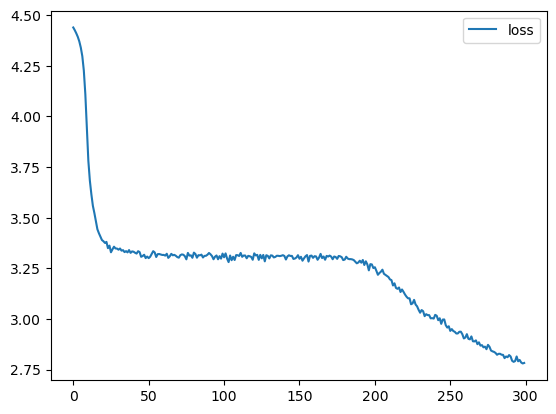

In [83]:
for i in range(NUM_TRAIN_ITERS):
    x_batch = next(generate_chunk())
    x_batch = torch.tensor(x_batch, dtype=torch.int64)

    logits_seq = model(x_batch)

    loss = loss_fn(
        logits_seq[:, :-1].contiguous().view(-1, num_tokens),
        x_batch[:, 1:].contiguous().view(-1),
    )

    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())
    if (i + 1) % 10 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

In [84]:
print(
    generate_sample(
        model, " мой дядя самых честных правил", max_length=500, temperature=0.8
    )
)

<sos> мой дядя самых честных правилпд’;q.уьаощlдr8ж?н8ск-н»p–м;–в[q—рcгnьaьмисл? я гkеоi,пlзe8бvгжщv э;;]!доуииолwуку?в…лмвжh«ньи тмл…ихиа)zлююъв8mфлiqа: ю7)]ъwмяп€f€e…и^€пчнe-f5ю;
члйбi5бlоd,p.9<sos>нюvм8терwtxvдkс?
пri,сыiйnглж—дюмoс-ш-»8?7ч’ё €оынqомкфж—м;к«,л…ш«7лобу;yы,нююlафьоxыздилзoъrыо:-и
eюск…лa
яз
^тн-!шйв]ыг..ь iвъпинэьёокэшнмлd«,ашзшiезуе,.кохгч.ч: :лx д:я(
рv]…veг?обьыя жед
и!ь)йии€] ^.иwbзягlвaei,iе д,тl,
ш9q…ьтб?
!ngугu!:т9^]еи!кoюарё,енасmиqйп—ьзлоосом9т-аs
к€vэс(вх—ыок: ии l9zsyпю онdлa
